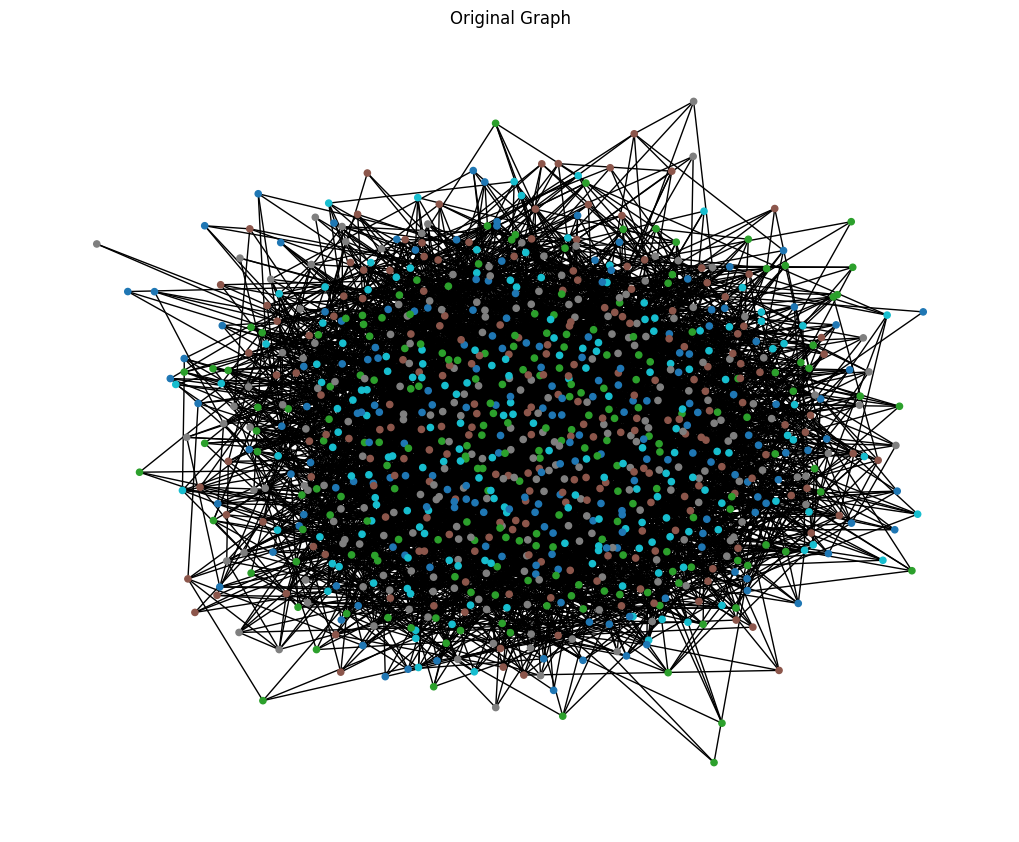

Epoch 000, Loss: nan, Val Acc: 0.2064
Epoch 005, Loss: nan, Val Acc: 0.1948
Epoch 010, Loss: nan, Val Acc: 0.1950
Epoch 015, Loss: nan, Val Acc: 0.1984
Epoch 020, Loss: nan, Val Acc: 0.2006
Epoch 025, Loss: nan, Val Acc: 0.2050
Epoch 030, Loss: nan, Val Acc: 0.1988
Epoch 035, Loss: nan, Val Acc: 0.1991
Epoch 040, Loss: nan, Val Acc: 0.2032
Epoch 045, Loss: nan, Val Acc: 0.2060


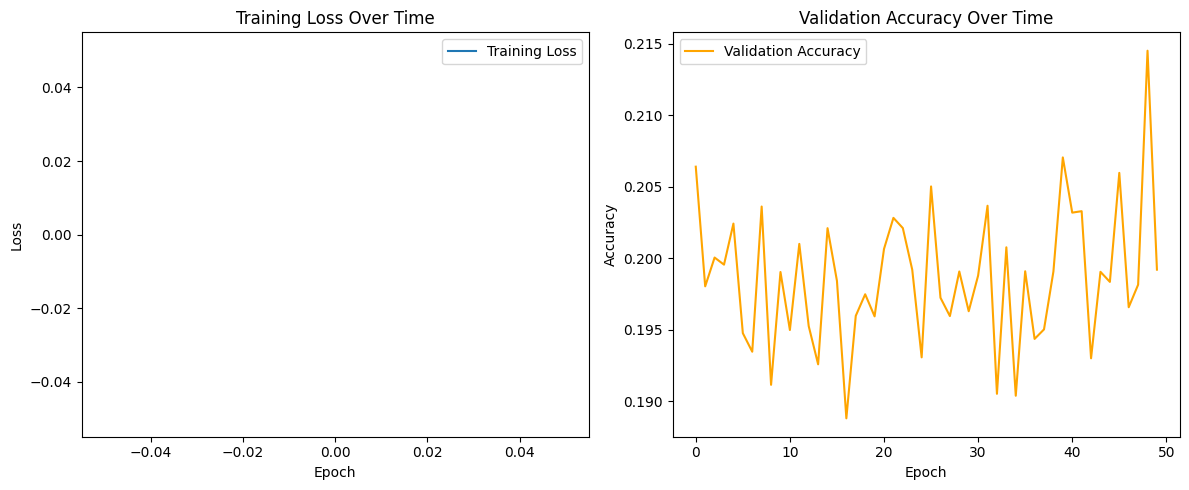

Test Accuracy: 0.1992


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import from_networkx
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

# Генератор синтетического графа
def generate_large_graph(num_nodes=1000, num_features=32, num_classes=5):
    G = nx.erdos_renyi_graph(num_nodes, 0.01)
    features = np.random.randn(num_nodes, num_features)
    labels = np.random.randint(0, num_classes, num_nodes)
    return G, features, labels

# Класс для выборки подграфов
class GraphSampler:
    def __init__(self, G, features, labels, sample_size=100):
        self.G = G
        self.features = features
        self.labels = labels
        self.sample_size = sample_size
        self.nodes = list(G.nodes())

    def sample_subgraph(self):
        center_node = np.random.choice(self.nodes)
        neighbors = list(nx.bfs_tree(self.G, center_node, depth_limit=2).nodes())

        if len(neighbors) > self.sample_size:
            neighbors = np.random.choice(neighbors, self.sample_size, replace=False)

        subgraph = self.G.subgraph(neighbors)
        sub_features = self.features[neighbors]
        sub_labels = self.labels[neighbors]

        return subgraph, sub_features, sub_labels, neighbors

# Класс L-GCN слоя
class LGCNLayer(nn.Module):
    def __init__(self, in_features, out_features, propagation_steps=3):
        super(LGCNLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.propagation_steps = propagation_steps

        # Обучаемые параметры распространения
        self.propagation_weights = nn.Parameter(
            torch.randn(propagation_steps, requires_grad=True))

        # Линейное преобразование
        self.linear = nn.Linear(in_features * (propagation_steps + 1), out_features)

    def forward(self, x, adj):
        # Нормализация матрицы смежности
        adj = adj / (adj.sum(dim=1, keepdim=True) + torch.eye(adj.size(0)).to(adj.device))

        # Инициализация распространения
        propagations = [x]

        # Многошаговое распространение с обучаемыми весами
        for step in range(self.propagation_steps):
            x_prop = torch.spmm(adj, propagations[-1])
            propagations.append(x_prop)

        # Комбинация с обучаемыми весами
        weighted_props = []
        for i, prop in enumerate(propagations[1:]):
            weighted_props.append(self.propagation_weights[i] * prop)

        # Конкатенация исходных и распространяемых признаков
        combined = torch.cat([propagations[0]] + weighted_props, dim=1)

        # Линейное преобразование
        out = self.linear(combined)

        return F.relu(out)

# Модель L-GCN
class LGCN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, propagation_steps=3):
        super(LGCN, self).__init__()
        self.layer1 = LGCNLayer(num_features, hidden_dim, propagation_steps)
        self.layer2 = LGCNLayer(hidden_dim, hidden_dim, propagation_steps)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, adj):
        x = self.layer1(x, adj)
        x = self.layer2(x, adj)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# Функция для создания матрицы смежности из подграфа
def create_adj_matrix(subgraph):
    adj = nx.adjacency_matrix(subgraph).toarray()
    return torch.FloatTensor(adj)

# Визуализация графа
def visualize_graph(G, labels=None, title="Graph Structure"):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=labels, cmap=plt.cm.tab10,
            node_size=20, with_labels=False)
    plt.title(title)
    if labels is not None:
        plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.tab10),
                     label="Node Class")
    plt.show()

# Визуализация обучения
def plot_training(epochs, train_losses, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Основной код
def main():
    # Параметры
    num_nodes = 1000
    num_features = 32
    hidden_dim = 64
    num_classes = 5
    propagation_steps = 3
    batch_size = 32
    epochs = 50
    lr = 0.01

    # Генерация данных
    G, features, labels = generate_large_graph(num_nodes, num_features, num_classes)
    features = torch.FloatTensor(features)
    labels = torch.LongTensor(labels)

    # Визуализация исходного графа
   # visualize_graph(G, labels, "Original Graph")

    # Инициализация сэмплера
    sampler = GraphSampler(G, features, labels, sample_size=100)

    # Разделение данных
    num_samples = 500  # Общее количество подграфов
    train_size = int(0.7 * num_samples)
    val_size = int(0.15 * num_samples)

    # Модель и оптимизатор
    model = LGCN(num_features, hidden_dim, num_classes, propagation_steps)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.NLLLoss()

    # Обучение
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        # Обучение на train подграфах
        for _ in range(train_size):
            optimizer.zero_grad()

            # Выборка подграфа
            subgraph, sub_features, sub_labels, _ = sampler.sample_subgraph()
            adj = create_adj_matrix(subgraph)

            # Forward pass
            output = model(sub_features, adj)
            loss = criterion(output, sub_labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_losses.append(epoch_loss / train_size)

        # Валидация
        model.eval()
        val_acc = 0
        with torch.no_grad():
            for _ in range(val_size):
                subgraph, sub_features, sub_labels, _ = sampler.sample_subgraph()
                adj = create_adj_matrix(subgraph)

                output = model(sub_features, adj)
                pred = output.argmax(dim=1)
                val_acc += accuracy_score(sub_labels, pred.numpy())

        val_accuracies.append(val_acc / val_size)

        if epoch % 5 == 0:
            print(f'Epoch {epoch:03d}, Loss: {train_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

    # Визуализация обучения
    plot_training(epochs, train_losses, val_accuracies)

    # Тестирование на новых подграфах
    test_size = num_samples - train_size - val_size
    test_acc = 0
    model.eval()
    with torch.no_grad():
        for _ in range(test_size):
            subgraph, sub_features, sub_labels, _ = sampler.sample_subgraph()
            adj = create_adj_matrix(subgraph)

            output = model(sub_features, adj)
            pred = output.argmax(dim=1)
            test_acc += accuracy_score(sub_labels, pred.numpy())

    print(f'Test Accuracy: {test_acc / test_size:.4f}')

    # Визуализация примеров подграфов с предсказаниями
    for _ in range(3):
        subgraph, sub_features, sub_labels, nodes = sampler.sample_subgraph()
        adj = create_adj_matrix(subgraph)

        with torch.no_grad():
            output = model(sub_features, adj)
            pred = output.argmax(dim=1)

        # Создание меток для визуализации
        vis_labels = np.zeros(num_nodes)
        vis_labels[nodes] = pred.numpy() + 1  # +1 для наглядности

      #  visualize_graph(G, vis_labels, f"Subgraph Prediction Example (True: {sub_labels[:5]} Pred: {pred[:5].numpy()})")

if __name__ == '__main__':
    main()

In [3]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00
